In this notebook I fit the microburst low Earth orbit Probability Density Function (PDF) with a variety of models. The optimizer is pymc3.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
import pymc3 as pm
import theano.tensor as tt

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


### Define a model
First lets code up a Maxwell (Maxwell-Boltzmann) distribution.

In [2]:
def maxwell(x, a):
    """ 
    Defines a Maxwell (otherwise known as 
    Maxwell-Boltzman or Maxwellian for plasmas) 
    PDF. Independent model parameter is a. 
    The distribution is evaluated at points
    given by array x. Interesting that I did 
    not have to define theano tensor variables
    beforehand i.e. a = tt.scalar('a') and
    x = tt.vector('x') is not necessary. To see 
    values use the eval() method to return an
    array instead of a theano tensor object.
    """
    inner = -x**2/(2*a**2)
    pdf = np.sqrt(2/np.pi)*(x**2/a**3)*tt.exp(inner)
    return pdf

Now confirm that our theno representation of a Maxwell distribution is the same as other sources e.g. wikipedia.

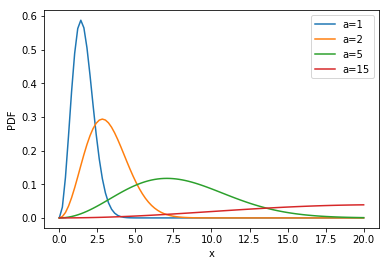

In [3]:
for a_i in [1, 2, 5, 15]:
    x = np.linspace(0, 20, num=100)
    y = maxwell(x, a_i)
    plt.plot(x, y.eval(), label=f'a={a_i}')
plt.legend()
plt.ylabel('PDF'); plt.xlabel('x');

Now lets code up a Gaussian profile

In [4]:
def gaus(x, mu, sigma):
    """ 
    Gaussian PDF written in theano. To see values
    use the eval() method to get an array back
    instead of a theano tensor object.
    """
    inner = -(x-mu)**2/(2*sigma**2)
    amplitude = tt.sqrt(2*np.pi*sigma**2)**(-1)
    pdf = amplitude*tt.exp(inner)
    return pdf

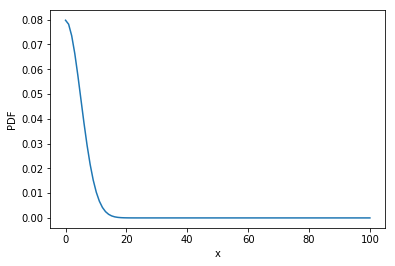

In [5]:
x = np.linspace(0, 100, num=100)
y = gaus(x, 0, 5)
plt.plot(x, y.eval())
plt.ylabel('PDF'); plt.xlabel('x');

## MCMC model

In [6]:
norm_std = 0.01

def model(x, y, dist, err=norm_std):
    """ 
    Define a pymc3 model
    """
    with pm.Model() as model:
        # Very simple model!
        if dist == maxwell:
            a = pm.Uniform('a', lower=0, upper=20)
            y_test = dist(x, a)
        elif dist == gaus:
            mu = pm.Uniform('mu', lower=0, upper=20)
            sigma = pm.Uniform('sigma', lower=0, upper=50)
            y_test = dist(x, mu, sigma)
        # Likelihood
        c_m = pm.Normal('c_m', mu=y_test, sd=err, observed=y)
        trace = pm.sample(int(1E4), tune=1000) # chains=1000, step=pm.SMC()
    return trace, c_m

### First lets fit artificial PDF to validate the model

In [7]:
a_test = 5
x = np.arange(0, 100, 5)
y = maxwell(x, a_test).eval()
y_test = np.array([np.random.normal(loc=y_i, scale=norm_std) for y_i in y])
y_test[y_test < 0] = 0

In [8]:
trace_test, c_test = model(x, y_test, maxwell)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a]
Sampling 4 chains: 100%|██████████| 44000/44000 [00:07<00:00, 5573.68draws/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Now validate the models in a few ways.

In [9]:
print(f'True a = {a_test}')

True a = 5


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
a,3.917412,1.105338,0.109374,1.922857,4.850298,2.033225,7.947708


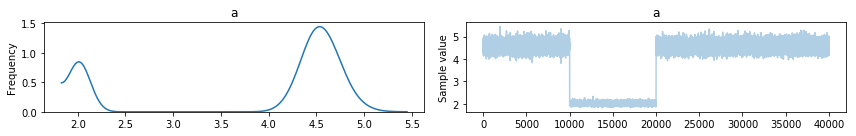

In [10]:
pm.traceplot(trace_test, combined=True);
pm.summary(trace_test)

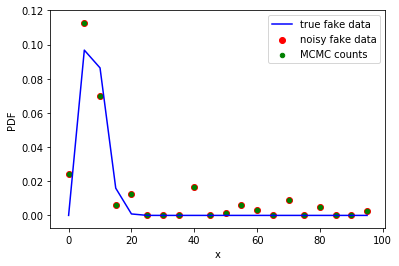

In [11]:
plt.plot(x, y, c='b', label='true fake data')
plt.scatter(x, y_test, c='r', label='noisy fake data');
plt.scatter(x, c_test.eval(), c='g', s=20, label='MCMC counts');
plt.legend(); plt.xlabel('x'); plt.ylabel('PDF');

Now, lets load a cdf/pdf dataset that I've generated in the ./../stats/microburst_CDF.ipynb and fit a Maxwell PDF to that.

In [12]:
cdf_data = pd.read_csv('/home/mike/research/ac6_microburst_scale_sizes/data/microburst_cdf_pdf_norm_v3.csv')
cdf_data.head()

,Dist_Total,CDF,CDF_err,PDF,PDF_err
0,2.0,1.000000,0.010736,0.065418,0.009807
1,7.0,0.672909,0.028416,0.025776,0.016578
2,12.0,0.544030,0.058373,0.015706,0.015199
3,17.0,0.465501,0.026004,0.005715,0.013879
4,22.0,0.436925,0.065402,0.023021,0.012800


In [13]:
trace, c_m = model(cdf_data.Dist_Total.values, cdf_data.PDF.values, maxwell)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a]
Sampling 4 chains: 100%|██████████| 44000/44000 [00:09<00:00, 4674.29draws/s]
There were 1351 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.10039636031144435, but should be close to 0.8. Try to increase the number of tuning steps.
There were 4357 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.30282539713705414, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9601127865422265, but should be close to 0.8. Try to increase the number of tuning steps.
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is sm

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
a,2.831526,5.81068,0.566679,0.561714,18.830177,10.213543,1.170738


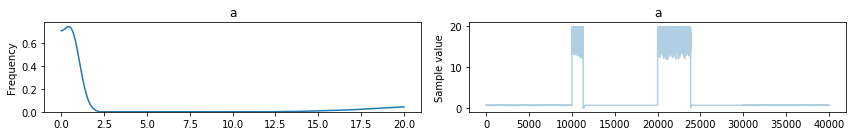

In [14]:
pm.traceplot(trace, combined=True);
pm.summary(trace)

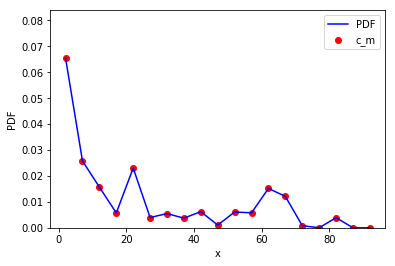

In [15]:
fig, ax = plt.subplots()
ax.scatter(cdf_data.Dist_Total, c_m.eval(), c='r', label='c_m')
cdf_data.plot(x='Dist_Total', y='PDF', ax=ax, c='b')
plt.legend(); plt.xlabel('x'); plt.ylabel('PDF'); plt.ylim(bottom=0);

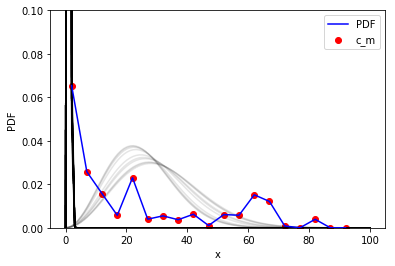

In [16]:
random_draws = np.random.choice(trace['a'], size=100)
fig, ax = plt.subplots()
x_plot = np.linspace(0, 100, num=100)

for a_i in random_draws:
    ax.plot(x_plot, maxwell(x_plot, a_i).eval(), c='k', alpha=0.1)
ax.scatter(cdf_data.Dist_Total, c_m.eval(), c='r', label='c_m')
cdf_data.plot(x='Dist_Total', y='PDF', ax=ax, c='b')
plt.legend(); plt.xlabel('x'); plt.ylabel('PDF'); plt.ylim(bottom=0, top=0.1);

### Now try to fit a Gaussian PDF

In [17]:
trace_gaus, c_m = model(cdf_data.Dist_Total.values, cdf_data.PDF.values, gaus)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]
Sampling 4 chains: 100%|██████████| 44000/44000 [00:11<00:00, 3801.11draws/s]
The acceptance probability does not match the target. It is 0.8991374722276163, but should be close to 0.8. Try to increase the number of tuning steps.


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mu,1.359518,1.267004,0.009767,0.000041,3.776418,15985.835015,1.000272
sigma,7.645714,2.197486,0.017931,4.423106,12.013866,12959.215068,1.000140


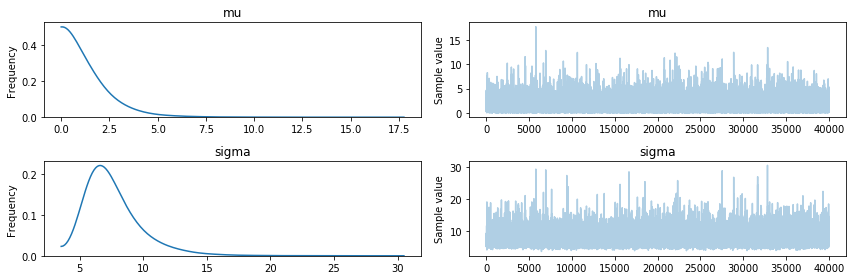

In [18]:
pm.traceplot(trace_gaus, combined=True);
pm.summary(trace_gaus)

INFO (theano.gof.compilelock): Refreshing lock /home/mike/.theano/compiledir_Linux-4.15--generic-x86_64-with-Ubuntu-18.04-bionic-x86_64-3.6.7-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/mike/.theano/compiledir_Linux-4.15--generic-x86_64-with-Ubuntu-18.04-bionic-x86_64-3.6.7-64/lock_dir/lock


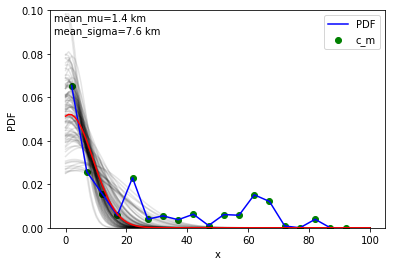

In [51]:
# Oragnize and pick 100 random pairs of mu and sigma from the fit.
gaus_params = np.array([trace_gaus['mu'], trace_gaus['sigma']]).T
random_draws = np.random.choice(np.arange(gaus_params.shape[0]), size=100)

# Find the mean set of model parameters
mean_mu = np.mean(trace_gaus['mu'])
mean_sigma = np.mean(trace_gaus['sigma'])

# Create subplot object.
fig, ax = plt.subplots()
x_plot = np.linspace(0, 100, num=100)

# Plot the 100 random Gaussian profiles taken from the trace
for i_p in random_draws:
    ax.plot(x_plot, gaus(x_plot, *gaus_params[i_p]).eval(), c='k', alpha=0.1)
# Plot the raw data.
ax.scatter(cdf_data.Dist_Total, c_m.eval(), c='g', label='c_m')
cdf_data.plot(x='Dist_Total', y='PDF', ax=ax, c='b')
ax.plot(x_plot, gaus(x_plot, mean_mu, mean_sigma).eval(), c='r')
plt.legend(); plt.xlabel('x'); plt.ylabel('PDF'); plt.ylim(bottom=0, top=0.1);
ax.text(0.01, 0.99, 
        f'mean_mu={round(mean_mu, 1)} km\nmean_sigma={round(mean_sigma, 1)} km', 
        ha='left', va='top', transform=ax.transAxes);
plt.savefig('mcmc_gaus_fit.png', dpi=300)

## Two Gaussian model
Now how about we try two Gaussians? No noise yet.

In [20]:
def model_2gaus(x, y, err=norm_std):
    """ 
    Define a pymc3 model
    """
    with pm.Model() as model:
        mu1 = pm.Uniform('mu1', lower=0, upper=20)
        sigma1 = pm.Uniform('sigma1', lower=0, upper=50)
        mu2 = pm.Uniform('mu2', lower=20, upper=100)
        sigma2 = pm.Uniform('sigma2', lower=0, upper=50)
        y_test = gaus(x, mu1, sigma1) + gaus(x, mu2, sigma2)
        # Likelihood
        c_m = pm.Normal('c_m', mu=y_test, sd=err, observed=y)
        trace = pm.sample(int(1E4), tune=1000) # chains=1000, step=pm.SMC()
    return trace, c_m

In [21]:
trace_2gaus, _ = model_2gaus(cdf_data.Dist_Total.values, cdf_data.PDF.values)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma2, mu2, sigma1, mu1]
Sampling 4 chains: 100%|██████████| 44000/44000 [00:16<00:00, 2707.56draws/s]


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mu1,0.881647,0.863608,0.005296,0.000018,2.557623,25187.837146,1.000283
sigma1,7.264977,1.954430,0.016159,4.417257,10.952572,13039.331976,1.000126
mu2,57.730984,22.224393,0.131424,20.008751,95.011599,32438.251754,1.000077
sigma2,41.868493,6.082368,0.038126,30.115282,49.999571,27355.990203,1.000136


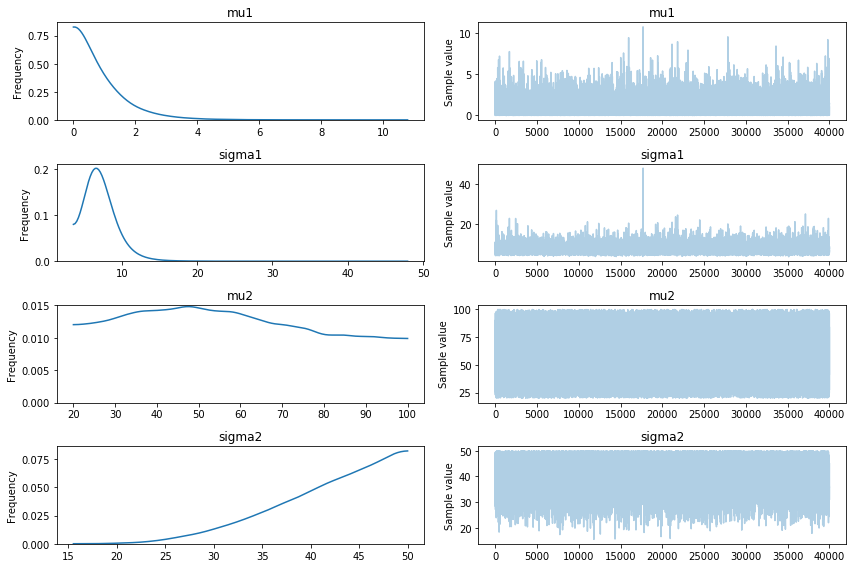

In [22]:
pm.traceplot(trace_2gaus, combined=True);
pm.summary(trace_2gaus)

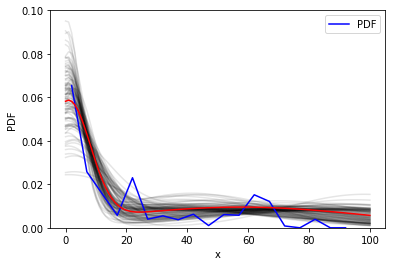

In [29]:
# Oragnize and pick 100 random pairs of mu and sigma from the fit.
gaus_params = np.array([trace_2gaus['mu1'], trace_2gaus['sigma1'], 
                        trace_2gaus['mu2'], trace_2gaus['sigma2']]).T
random_draws = np.random.choice(np.arange(gaus_params.shape[0]), size=100)

# Find the mean set of model parameters
mean_mu1 = np.mean(trace_2gaus['mu1'])
mean_sigma1 = np.mean(trace_2gaus['sigma1'])
mean_mu2 = np.mean(trace_2gaus['mu2'])
mean_sigma2 = np.mean(trace_2gaus['sigma2'])

# Create subplot object.
fig, ax = plt.subplots()
x_plot = np.linspace(0, 100, num=100)

# Plot the 100 random Gaussian profiles taken from the trace
for i_p in random_draws:
    ax.plot(x_plot, gaus(x_plot, *gaus_params[i_p, :2]).eval() +
                    gaus(x_plot, *gaus_params[i_p, 2:]).eval(), 
            c='k', alpha=0.1)
# Plot the raw data.
# ax.scatter(cdf_data.Dist_Total, c_m.eval(), c='g', label='c_m')
cdf_data.plot(x='Dist_Total', y='PDF', ax=ax, c='b')
ax.plot(x_plot, gaus(x_plot, mean_mu1, mean_sigma1).eval() + 
                gaus(x_plot, mean_mu2, mean_sigma2).eval(), 
        c='r')
plt.legend(); plt.xlabel('x'); plt.ylabel('PDF'); plt.ylim(bottom=0, top=0.1);

## Now lets try the same thing again, but with added uncertanity. 

In [24]:
trace_gaus_err, _ = model(cdf_data.Dist_Total.values[:-2], cdf_data.PDF.values[:-2], gaus, 
                       err=cdf_data.PDF_err.values[:-2])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]
Sampling 4 chains: 100%|██████████| 44000/44000 [00:11<00:00, 3976.30draws/s]
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8861142344635539, but should be close to 0.8. Try to increase the number of tuning steps.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mu,19.072671,0.815319,0.005127,17.436486,19.999842,21900.655172,1.000089
sigma,48.498513,1.218524,0.008870,46.088740,49.999730,20093.869336,1.000257


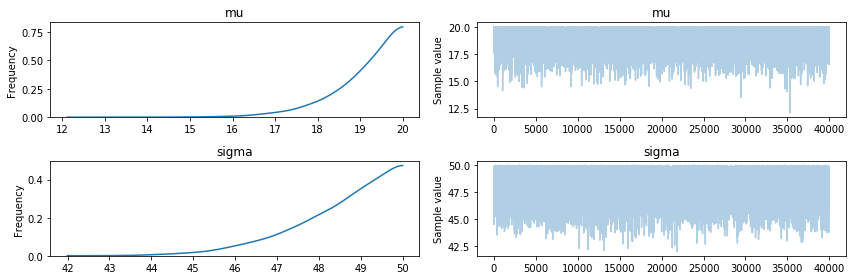

In [25]:
pm.traceplot(trace_gaus_err, combined=True);
pm.summary(trace_gaus_err)

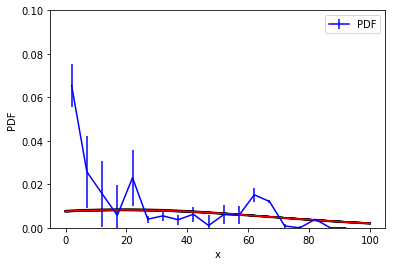

In [26]:
# Oragnize and pick 100 random pairs of mu and sigma from the fit.
gaus_params = np.array([trace_gaus_err['mu'], trace_gaus_err['sigma']]).T
random_draws = np.random.choice(np.arange(gaus_params.shape[0]), size=100)

# Find the mean set of model parameters
mean_mu = np.mean(trace_gaus_err['mu'])
mean_sigma = np.mean(trace_gaus_err['sigma'])

# Create subplot object.
fig, ax = plt.subplots()
x_plot = np.linspace(0, 100, num=100)

# Plot the 100 random Gaussian profiles taken from the trace
for i_p in random_draws:
    ax.plot(x_plot, gaus(x_plot, *gaus_params[i_p]).eval(), c='k', alpha=0.1)
# Plot the raw data.
#ax.scatter(cdf_data.Dist_Total, c_m.eval(), c='g', label='c_m')
# cdf_data.plot(x='Dist_Total', y='PDF', ax=ax, c='b')
ax.errorbar(cdf_data.Dist_Total, cdf_data.PDF, c='b', yerr=cdf_data.PDF_err)
ax.plot(x_plot, gaus(x_plot, mean_mu, mean_sigma).eval(), c='r')
plt.legend(); plt.xlabel('x'); plt.ylabel('PDF'); plt.ylim(bottom=0, top=0.1);